<a href="https://colab.research.google.com/github/armandoordonez/eda_couse/blob/main/Custom_transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# dataset url 'https://www.kaggle.com/c/house-prices-advanced-regression-techniques'
# Based on: https://medium.com/@benlc77/how-to-write-clean-and-scalable-code-with-custom-transformers-sklearn-pipelines-ecb8e53fe110


import pandas as pd
import numpy as np

train = pd.read_csv("https://raw.githubusercontent.com/armandoordonez/eda_couse/main/data/kaggle_house_prices_train.csv", index_col ='Id')
test = pd.read_csv("https://raw.githubusercontent.com/armandoordonez/eda_couse/main/data/kaggle_house_prices_test.csv", index_col ='Id')

# Definimos las variables dependientes  e independientes

X = train.drop('SalePrice', axis = 1)
y = train['SalePrice']

train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
train.shape

(1460, 80)

<Axes: >

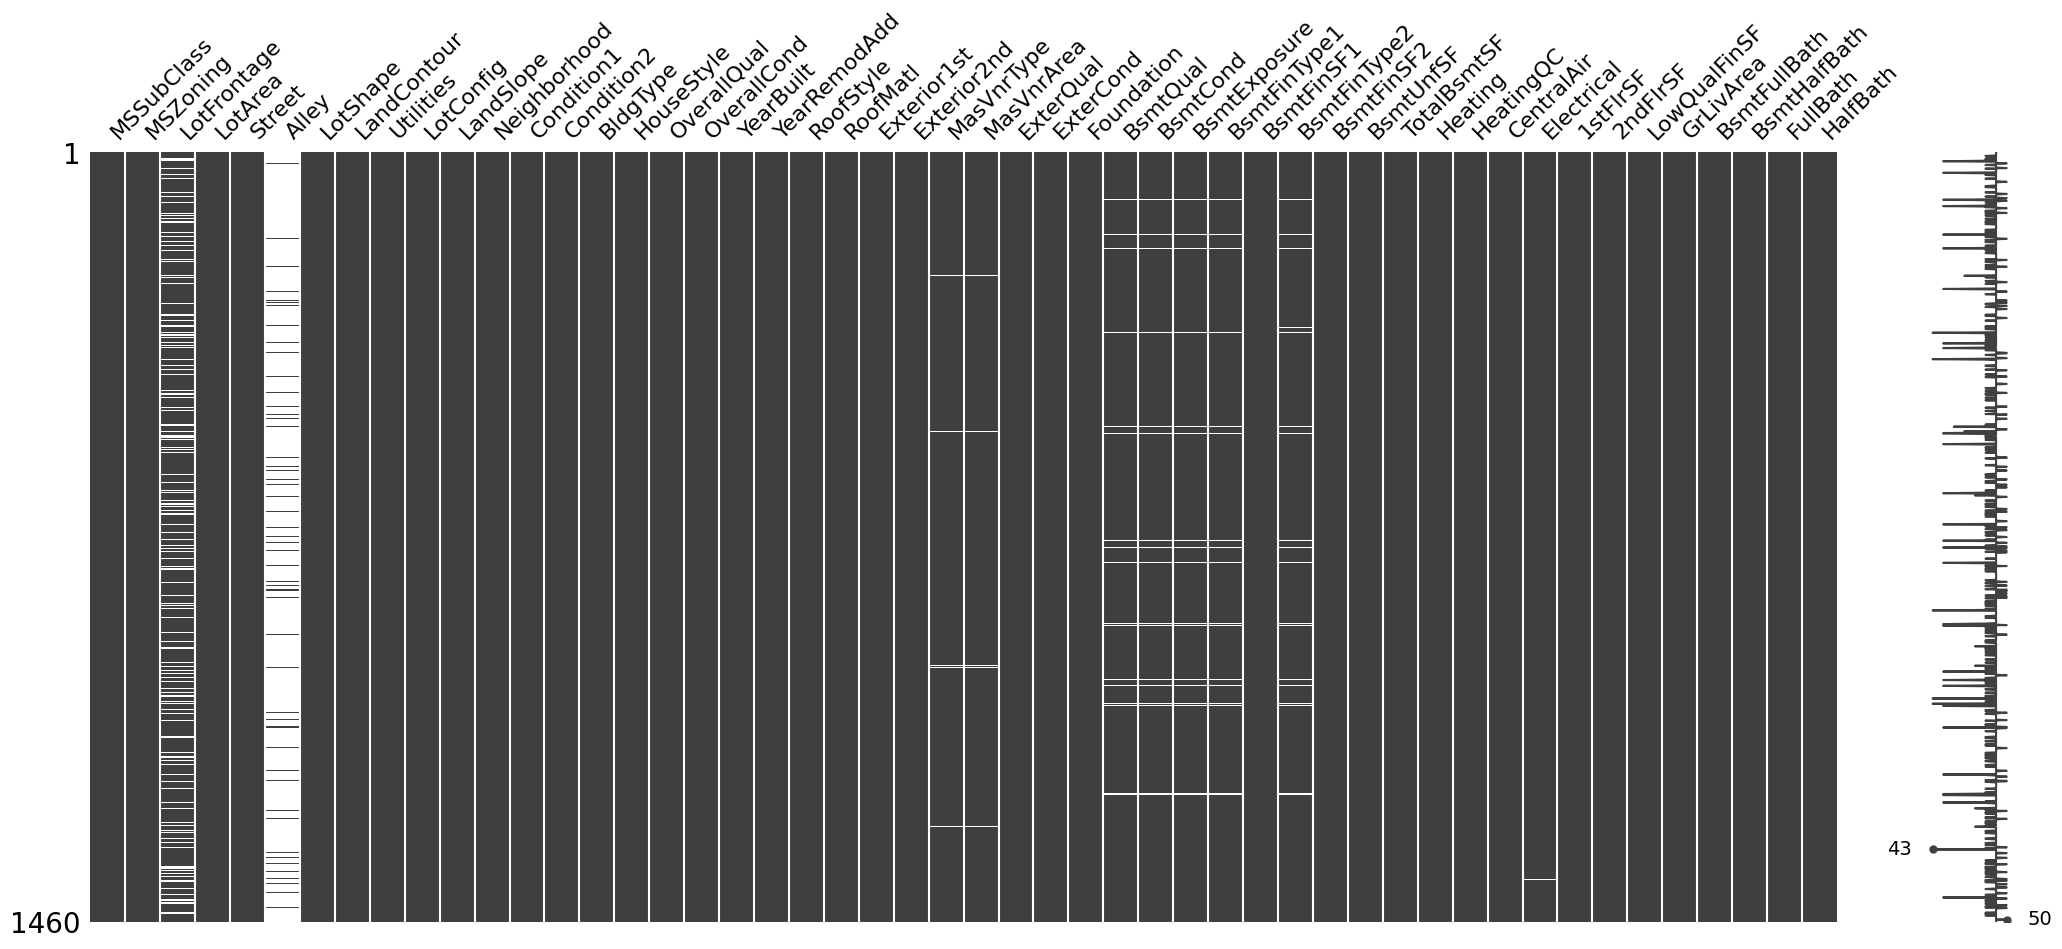

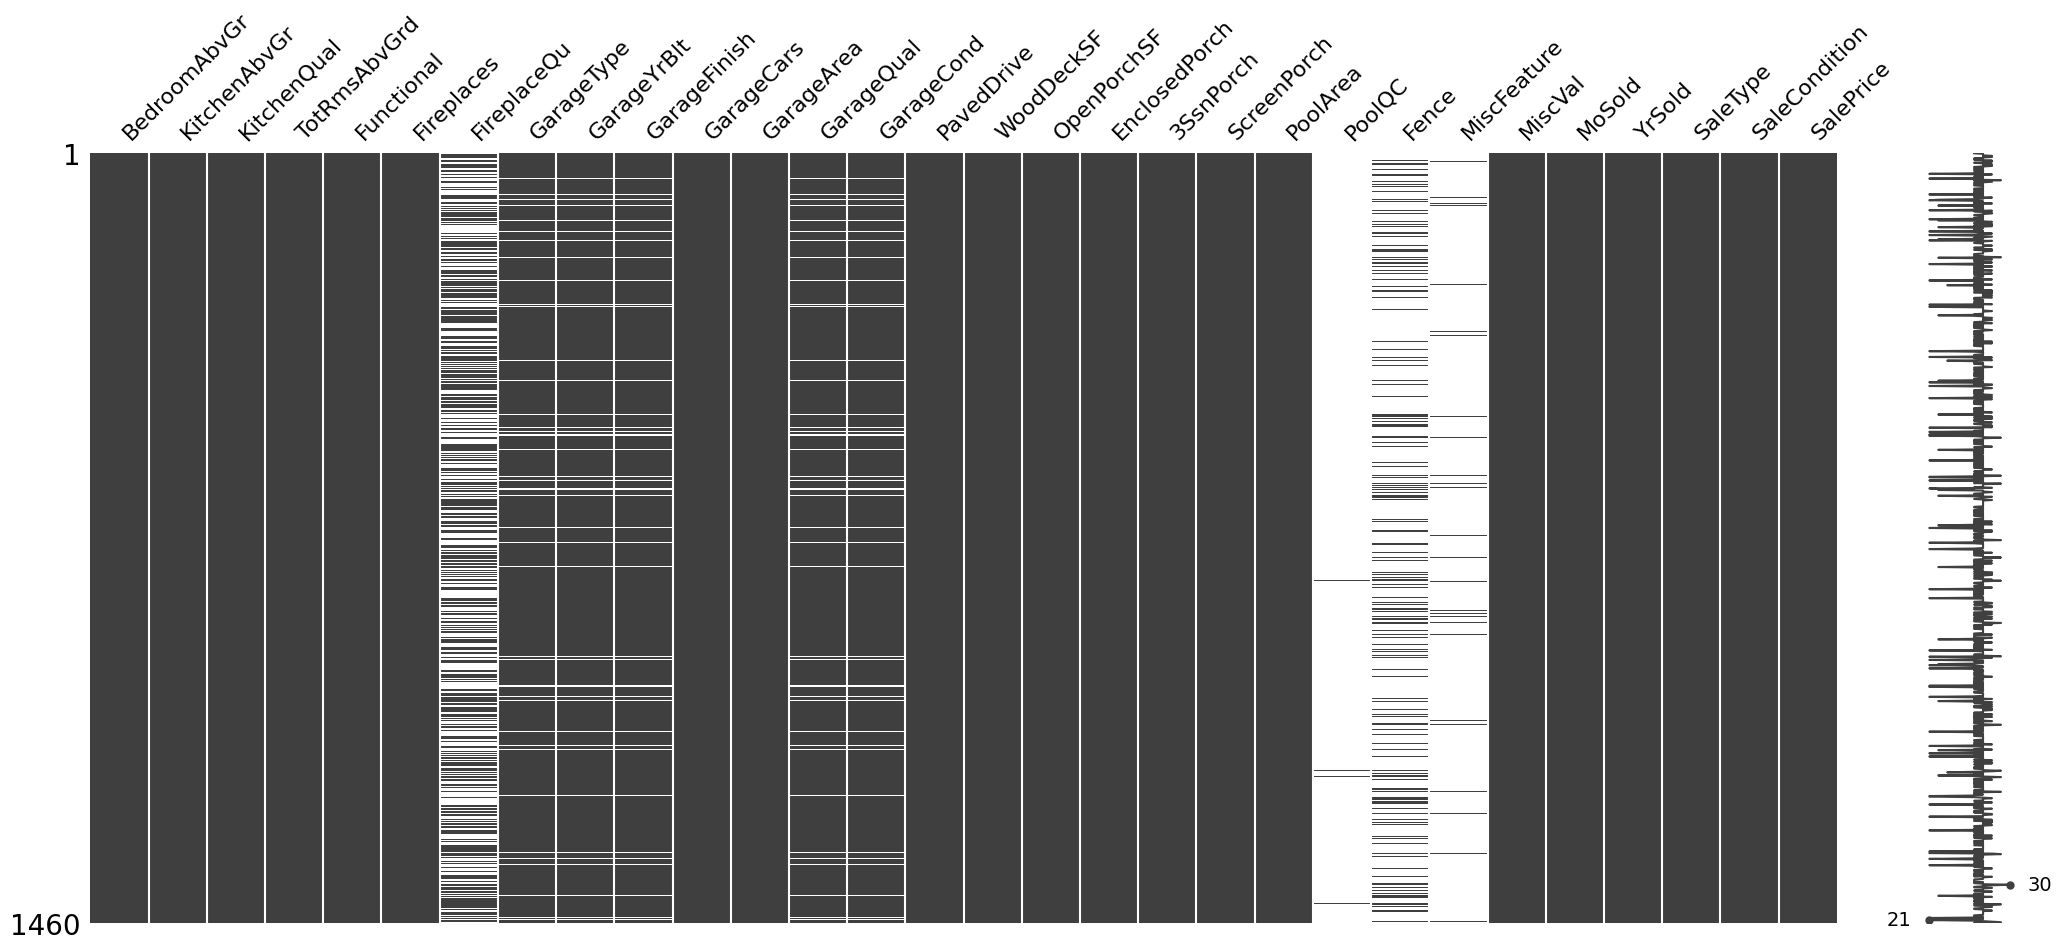

In [7]:
import missingno as msno

# ver los valores perdidos de forma gráfica

msno.matrix(train.iloc[:,:50])
msno.matrix(train.iloc[:,50:])

# 1. Define a workflow


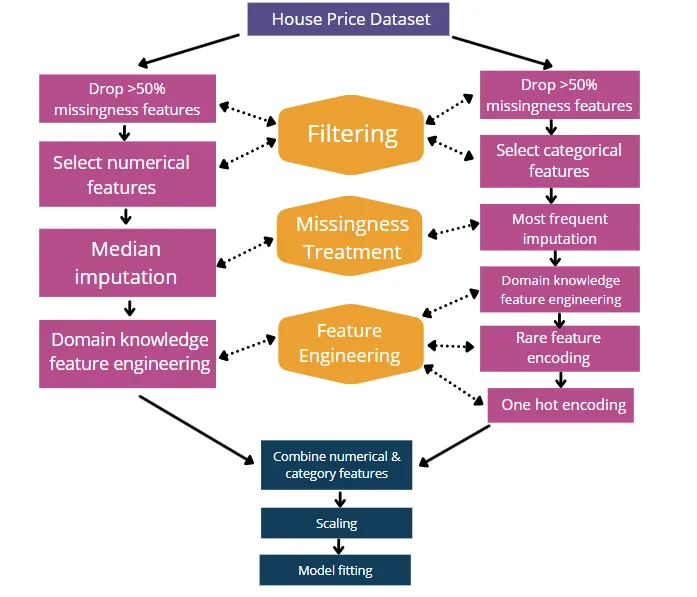

# 2. Custom transformers

In [8]:

from sklearn.base import BaseEstimator, TransformerMixin

class DropFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, variables):
        self.variables = variables
    def fit(self, X, y = None):
        return self
    def transform(self, X):
        X_dropped = X.drop(self.variables, axis = 1)
        self.columns = X_dropped.columns
        return X_dropped

In [9]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

# create train & validation set
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=123)

# Crear un escaladora
scaler = StandardScaler()

# instanciamos la clase creada
dropper = DropFeatureSelector(['MSSubClass'])

# initialise regression model
lr = LinearRegression()

# build pipeline
complete_pipeline = Pipeline([    ('preprocessing', dropper),    ('StandardScaler', scaler),    ('Model Training', lr)])



In [10]:
!pip install feature-engine

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 328.9/328.9 kB 4.7 MB/s eta 0:00:00


In [11]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import KFold, cross_val_score
from feature_engine import encoding

In [12]:
# create custom transformer
class DropFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, variables):
        self.variables = variables
    def fit(self, X, y = None):
        return self
    def transform(self, X):
        X_dropped = X.drop(self.variables, axis = 1)
        return X_dropped

class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, variables):
        self.variables = variables
    def fit(self, X, y = None):
        return self
    def transform(self, X):
        return X.loc[:,self.variables]

class SimpleImputerCustom(BaseEstimator, TransformerMixin):
    def __init__(self, variables, strategy):
        self.variables = variables
        self.strategy = strategy
        self.imp = SimpleImputer(missing_values=np.nan,
                    strategy=self.strategy)
    def fit(self, X, y = None):
        X_ = X.loc[:,self.variables]
        self.imp.fit(X_)
        return self
    def transform(self, X):
        X_ = X.loc[:,self.variables]
        X_transformed = pd.DataFrame(self.imp.transform(X_),
                         columns= self.variables)
        X.drop(self.variables, axis= 1, inplace=True)
        X[self.variables] = X_transformed[self.variables].values
        return X


In [13]:

class DomainNumFE(BaseEstimator, TransformerMixin):
    def __init__(self, variables = None):
        self.variables = variables
    def fit(self, X, y =None):
        return self
    def transform(self, X):
        # source: https://www.kaggle.com/lavanyashukla01/how-i-made-top-0-3-on-a-kaggle-competition#Feature-Engineering
        X_ = X.copy()
        X_['HasWoodDeck'] = (X_['WoodDeckSF'] == 0) * 1
        X_['HasOpenPorch'] = (X_['OpenPorchSF'] == 0) * 1
        X_['HasEnclosedPorch'] = (X_['EnclosedPorch'] == 0) * 1
        X_['Has3SsnPorch'] = (X_['3SsnPorch'] == 0) * 1
        X_['HasScreenPorch'] = (X_['ScreenPorch'] == 0) * 1
        X_['YearsSinceRemodel'] = X_['YrSold'].astype(int) - X_['YearRemodAdd'].astype(int)
        X_['Total_Home_Quality'] = X_['OverallQual'] +             X_['OverallCond']
        X_['TotalSF'] = X_['TotalBsmtSF'] + X_['1stFlrSF'] +            X_['2ndFlrSF']
        X_['YrBltAndRemod'] = X_['YearBuilt'] + X_['YearRemodAdd']
        X_['Total_sqr_footage'] = (X_['BsmtFinSF1'] +   X_['BsmtFinSF2'] + X_['1stFlrSF'] + X_['2ndFlrSF'])
        X_['Total_porch_sf'] = (X_['OpenPorchSF'] + X_['3SsnPorch'] + X_['EnclosedPorch'] + X_['ScreenPorch'] + X_['WoodDeckSF'])
        X_['TotalBsmtSF'] = X_['TotalBsmtSF'].apply(lambda x:             np.exp(6) if x <= 0.0 else x)
        X_['2ndFlrSF'] = X_['2ndFlrSF'].apply(lambda x: np.exp(6.5)
            if x <= 0.0 else x)
        X_['GarageArea'] = X_['GarageArea'].apply(lambda x:             np.exp(6) if x <= 0.0 else x)
        X_['LotFrontage'] = X_['LotFrontage'].apply(lambda x:            np.exp(4.2) if x <= 0.0 else x)
        X_['MasVnrArea'] = X_['MasVnrArea'].apply(lambda x:             np.exp(4) if x <= 0.0 else x)
        X_['BsmtFinSF1'] = X_['BsmtFinSF1'].apply(lambda x:             np.exp(6.5) if x <= 0.0 else x)
        X_['haspool'] = X_['PoolArea'].apply(lambda x: 1 if x > 0            else 0)
        X_['has2ndfloor'] = X_['2ndFlrSF'].apply(lambda x: 1             if x > 0 else 0)
        X_['hasgarage'] = X_['GarageArea'].apply(lambda x: 1             if x > 0 else 0)
        X_['hasbsmt'] = X_['TotalBsmtSF'].apply(lambda x: 1             if x > 0 else 0)
        return X_



In [14]:
class OneHotEncodercustom(BaseEstimator, TransformerMixin):
    def __init__(self, variables):
        self.variables = variables
        self.ohe = OneHotEncoder(drop='first',             handle_unknown = 'ignore')
    def fit(self, X, y = None):
        X_ = X.loc[:,self.variables]
        self.ohe.fit(X_)
        return self
    def transform(self, X):
        X_ = X.loc[:,self.variables]
        X_transformed =              pd.DataFrame(self.ohe.transform(X_).toarray(),            columns= self.ohe.get_feature_names_out())
        X.drop(self.variables, axis= 1, inplace=True)
        X[self.ohe.get_feature_names_out()] = X_transformed[self.ohe.get_feature_names_out()].values
        return X



In [15]:
class DomainCatFE(BaseEstimator, TransformerMixin):
    def __init__(self, variables = None):
        self.variables = variables
    def fit(self, X, y =None):
        return self
    def transform(self, X):
    # source: https://www.kaggle.com/lavanyashukla01/how-i-made-top-0-3-on-a-kaggle-competition#Feature-Engineering
      X_ = X.copy()
      X_['BsmtFinType1_Unf'] = 1*(X_['BsmtFinType1'] == 'Unf')
      X_['Total_Bathrooms'] = (X_['FullBath'] + (0.5 * X_['HalfBath'])          + X_['BsmtFullBath'] + (0.5 * X_['BsmtHalfBath']))
      X_['GarageCars'] = X_['GarageCars'].apply(lambda x: 0
        if x <= 0.0 else x)
      X_['hasfireplace'] = X_['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)
      return X_

In [16]:
# list for numerical columns
numerical_cols = ['LotFrontage','MasVnrArea','GarageYrBlt',
    'MSSubClass','LotArea','OverallQual','OverallCond',
    'YearBuilt','YearRemodAdd','BsmtFinSF1','BsmtFinSF2',
    'BsmtUnfSF','TotalBsmtSF','1stFlrSF','2ndFlrSF',
    'LowQualFinSF','GrLivArea','BedroomAbvGr','TotRmsAbvGrd',
    'GarageArea','WoodDeckSF','OpenPorchSF','EnclosedPorch',
    '3SsnPorch','ScreenPorch','PoolArea','YrSold','MiscVal',
    'MoSold']

# list for one hot encoding columns
ohe_cols = ['MSZoning', 'Street',  'LotShape','LandContour',
    'Utilities','LotConfig', 'LandSlope', 'Neighborhood',
    'Condition1', 'Condition2','BldgType', 'HouseStyle',
    'RoofStyle','RoofMatl', 'Exterior1st','Exterior2nd',
    'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
    'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
    'BsmtFinType2','Heating', 'HeatingQC', 'CentralAir',
    'Electrical', 'KitchenQual','Functional', 'GarageType',
    'GarageFinish', 'GarageQual','GarageCond', 'PavedDrive',
    'SaleType', 'SaleCondition']
# list for categorical columns
categories_cols = ohe_cols + ['BsmtFullBath','BsmtHalfBath',
    'FullBath','HalfBath','KitchenAbvGr','Fireplaces',
    'GarageCars']

In [17]:
# initialise numerical preprocessing step
drop_features = DropFeatureSelector(variables=['PoolQC', 'Fence', 'MiscFeature','FireplaceQu','Alley'])
num_feature_selector = FeatureSelector(variables=numerical_cols)
median_imputer = SimpleImputerCustom(variables=['LotFrontage',    'MasVnrArea', 'GarageYrBlt','BsmtFinSF1',    'BsmtFinSF2','BsmtUnfSF','TotalBsmtSF', 'GarageArea'],    strategy='median')
num_fe_domain_knowledge = DomainNumFE()

# build preprocessing step for numerical data
num_preprocessing_pipe = Pipeline(
    steps=[
        ('drop_features',drop_features),
        ("num_feature_selector", num_feature_selector),
        ('median_imputer',median_imputer),
        ('num_fe_domain_knowledge',num_fe_domain_knowledge)
    ]
)

In [18]:
# initialise categorical preprocessing step
cat_feature_selector = FeatureSelector(variables=categories_cols)
mostfrequent_imputer = SimpleImputerCustom(variables=
    ['GarageType','GarageFinish', 'GarageQual','GarageCond',
     'MasVnrType','BsmtQual', 'BsmtCond', 'BsmtExposure',
     'BsmtFinType1','BsmtFinType2', 'Electrical','MSZoning',
     'Utilities','Exterior1st','Exterior2nd','BsmtFullBath',
     'BsmtHalfBath','KitchenQual','Functional','GarageCars',
     'SaleType'], strategy='most_frequent')
rare_encoder = encoding.RareLabelEncoder(tol=0.20, n_categories=2,
    variables=ohe_cols, replace_with='rare')
ohe = OneHotEncodercustom(variables=ohe_cols)
cat_fe_domain_knowledge = DomainCatFE()

# build preprocessing step for categorical data
cat_preprocessing_pipe = Pipeline(steps=[
    ('drop_features',drop_features),
    ("cat_feature_selector", cat_feature_selector),
    ('mostfrequent_imputer',mostfrequent_imputer),
    ('cat_fe_domain_knowledge',cat_fe_domain_knowledge),
    ('rare_encoder',rare_encoder),
    ('ohe',ohe)
])

In [19]:
# combine both numerical and categorical preprocessing step
combined_preprocessing = FeatureUnion([
    ('numericals', num_preprocessing_pipe),
    ('categoricals', cat_preprocessing_pipe),
])

In [20]:
import warnings
warnings.filterwarnings("ignore")

# create train & validation set
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=123)

# initialise regression model
lr = LinearRegression()
rf = RandomForestRegressor()
ada = AdaBoostRegressor()


models ={"Linear Regression":lr,
    "Random Forest Regression":rf,
    "AdaBoost Regressor":ada}

scaler = StandardScaler()

# build final pipeline

for name, model in models.items():

    complete_pipeline = Pipeline([
        ('preprocessing', combined_preprocessing),
        ('StandardScaler', scaler),
        ('Model Training', model)
    ])

    # model fitting
    complete_pipeline.fit(X_train, y_train)

    # model scoring
    train_pred = complete_pipeline.predict(X_train)
    valid_pred = complete_pipeline.predict(X_valid)

    # Evaluate model performance
    print('*' * 50)
    print(f'{name} Training score:')
    print(f'MAE: {round(mean_absolute_error(y_train, train_pred),4)} | RMSE: {round(mean_squared_error(y_train, train_pred, squared=False),4)} | R2: {round(r2_score(y_train, train_pred),4)}')
    print('-' * 20)
    print(f'{name} Validation score:')
    print(f'MAE: {round(mean_absolute_error(y_valid, valid_pred),4)} | RMSE: {round(mean_squared_error(y_valid, valid_pred, squared=False),4)} | R2: {round(r2_score(y_valid, valid_pred),4)}')

**************************************************
Linear Regression Training score:
MAE: 18461.9043 | RMSE: 29586.6963 | R2: 0.8632
--------------------
Linear Regression Validation score:
MAE: 18809.1892 | RMSE: 28561.6102 | R2: 0.8647
**************************************************
Random Forest Regression Training score:
MAE: 6561.2152 | RMSE: 11092.601 | R2: 0.9808
--------------------
Random Forest Regression Validation score:
MAE: 16306.9945 | RMSE: 26155.2096 | R2: 0.8866
**************************************************
AdaBoost Regressor Training score:
MAE: 20438.6502 | RMSE: 25825.4843 | R2: 0.8957
--------------------
AdaBoost Regressor Validation score:
MAE: 22351.0534 | RMSE: 34354.2339 | R2: 0.8043


In [21]:
!wget --no-check-certificate -O application_train.csv 'https://drive.google.com/u/0/uc?id=1uPXB-Hr8TzUNyGVEEwRAEIy9pYbBskNS&export=download'

--2024-03-06 14:49:00--  https://drive.google.com/u/0/uc?id=1uPXB-Hr8TzUNyGVEEwRAEIy9pYbBskNS&export=download
Resolving drive.google.com (drive.google.com)... 74.125.135.113, 74.125.135.138, 74.125.135.101, ...
Connecting to drive.google.com (drive.google.com)|74.125.135.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://drive.google.com/uc?id=1uPXB-Hr8TzUNyGVEEwRAEIy9pYbBskNS&export=download [following]
--2024-03-06 14:49:00--  https://drive.google.com/uc?id=1uPXB-Hr8TzUNyGVEEwRAEIy9pYbBskNS&export=download
Reusing existing connection to drive.google.com:443.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1uPXB-Hr8TzUNyGVEEwRAEIy9pYbBskNS&export=download [following]
--2024-03-06 14:49:01--  https://drive.usercontent.google.com/download?id=1uPXB-Hr8TzUNyGVEEwRAEIy9pYbBskNS&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 108.177.98.132, 2607:

In [22]:
import pandas as pd

df = pd.read_csv('application_train.csv', sep=',')
df.head()


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin


#Custom Transformer that extracts columns passed as argument to its constructor

class ColumnSelector(BaseEstimator, TransformerMixin):
    #Class Constructor
    def __init__( self, feature_names ):
        self._feature_names = feature_names

    #Return self nothing else to do here
    def fit( self, X, y = None ):
        return self

    #Method that describes what we need this transformer to do
    def transform( self, X, y = None ):
        return X[ self._feature_names ]